In [145]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from rubin_scheduler.scheduler.utils import SchemaConverter

In [146]:
desc_file = "ddf_desc_0.70_sn.npy"

In [147]:
loaded_ddfs = np.load(desc_file)

In [148]:
d = pd.DataFrame(loaded_ddfs)

In [149]:
d.head()

,ID,RA,dec,mjd,flush_by_mjd,exptime,band,rotSkyPos,rotTelPos,rotTelPos_backup,...,observation_reason,mjd_tol,dist_tol,alt_min,alt_max,HA_max,HA_min,sun_alt_max,moon_min_distance,observed
0,0,0.164934,-0.768381,60981.0,60983.0,30.0,u,0.0,0.0,0.0,...,FBS,0.010417,0.017453,0.436332,1.48353,3.0,21.0,-0.314159,0.436332,False
1,0,0.164934,-0.768381,60981.0,60983.0,30.0,u,0.0,0.0,0.0,...,FBS,0.010417,0.017453,0.436332,1.48353,3.0,21.0,-0.314159,0.436332,False
2,0,0.164934,-0.768381,60981.0,60983.0,30.0,u,0.0,0.0,0.0,...,FBS,0.010417,0.017453,0.436332,1.48353,3.0,21.0,-0.314159,0.436332,False
3,0,0.164934,-0.768381,60981.0,60983.0,30.0,u,0.0,0.0,0.0,...,FBS,0.010417,0.017453,0.436332,1.48353,3.0,21.0,-0.314159,0.436332,False
4,0,0.164934,-0.768381,60981.0,60983.0,30.0,u,0.0,0.0,0.0,...,FBS,0.010417,0.017453,0.436332,1.48353,3.0,21.0,-0.314159,0.436332,False


In [150]:
# What does the flush time look like?
x = (d.flush_by_mjd - d.mjd)
x.mean(), x.min(), x.max()

(np.float64(2.0), 2.0, 2.0)

DD:ELAISS1 35.0 17.0 17.832535885167463
DD:XMM_LSS 167.0 17.0 80.10250569476082
DD:ECDFS 35.0 17.0 18.26365054602184
DD:COSMOS 167.0 35.0 79.48884381338742
DD:EDFS_a 35.0 17.0 18.341614906832298
DD:EDFS_b 35.0 17.0 18.341614906832298


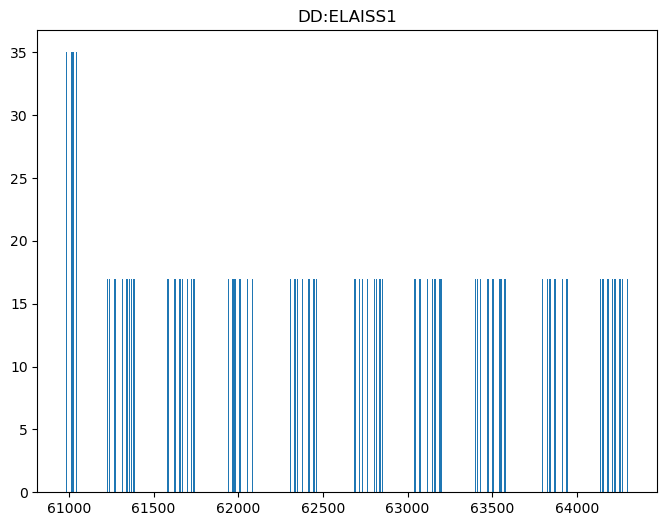

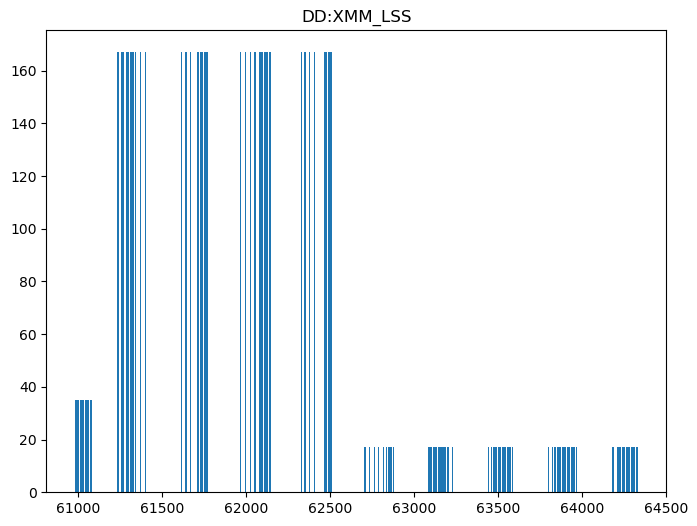

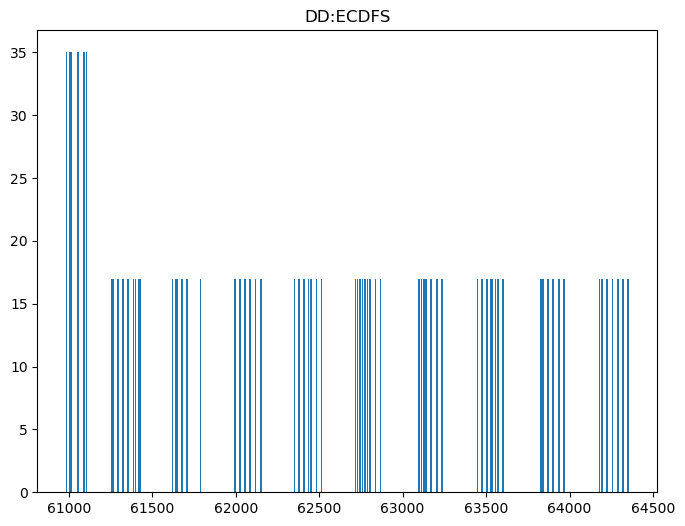

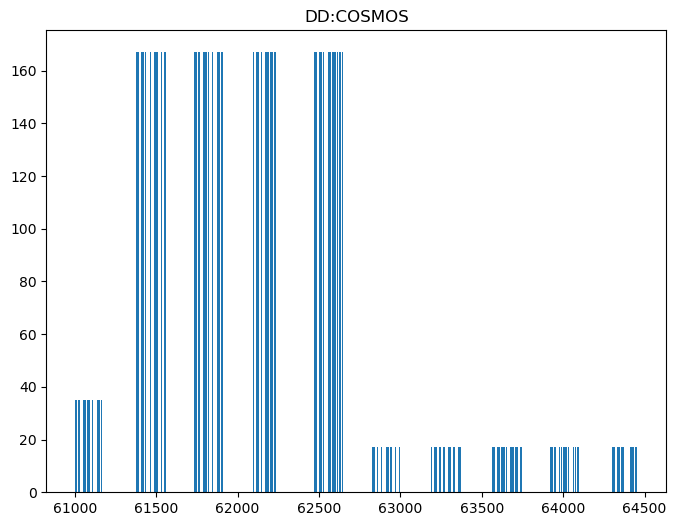

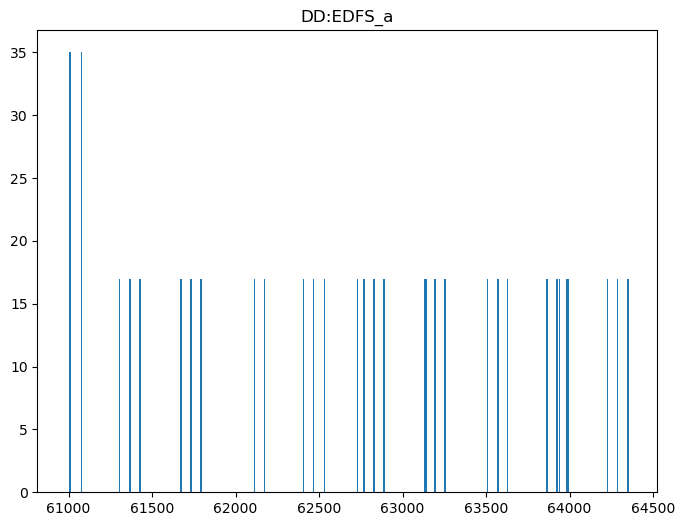

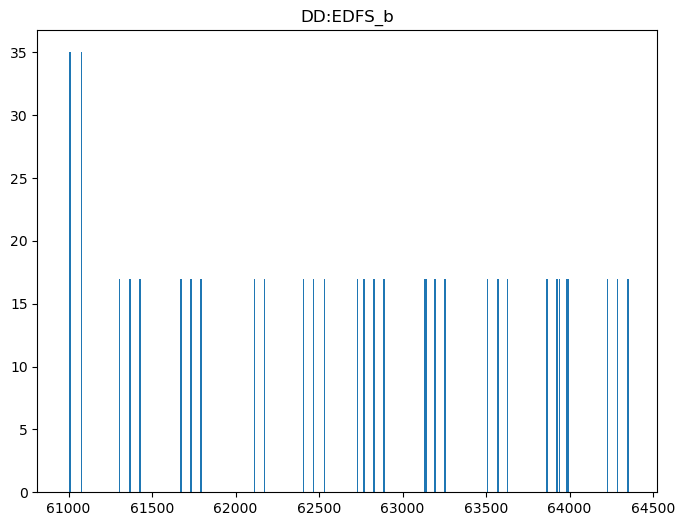

In [151]:
# What does the overall sequence length look like and when do they happen?
for ddf in d.scheduler_note.unique():
    q = d.query("scheduler_note == @ddf")
    plt.figure(figsize=(8, 6))
    n,b,p = plt.hist(q.mjd, bins=np.arange(q.mjd.min(), q.mjd.max()+0.5, 1))
    plt.title(ddf)
    x = n[np.where(n>0)]
    print(ddf, np.max(x), np.median(x), np.mean(x))
    

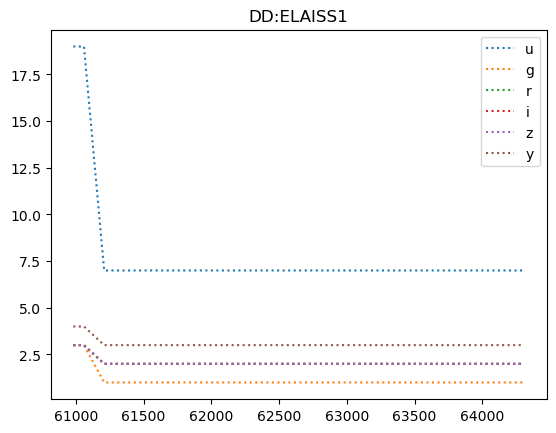

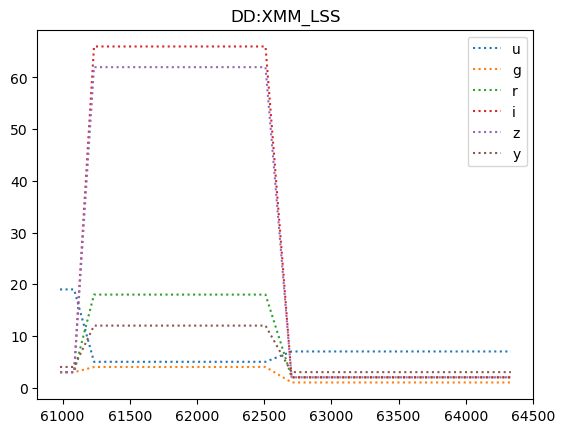

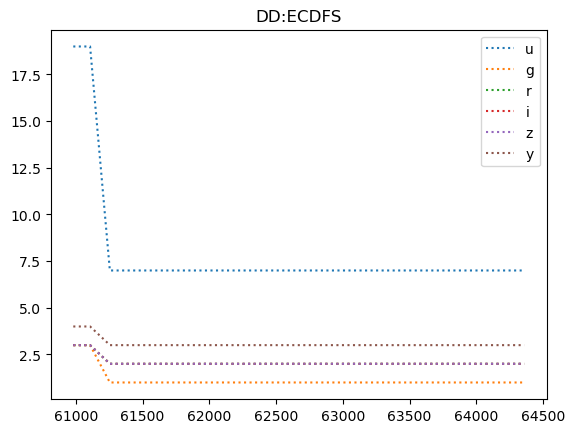

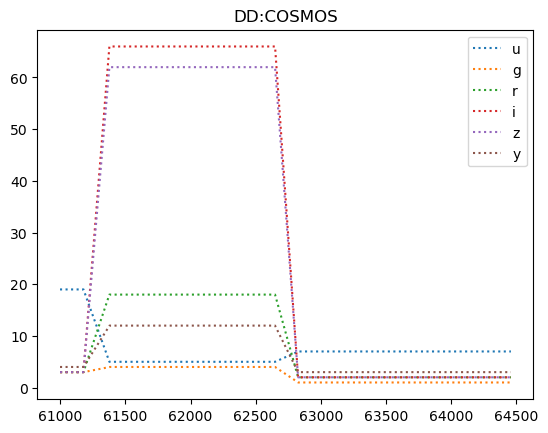

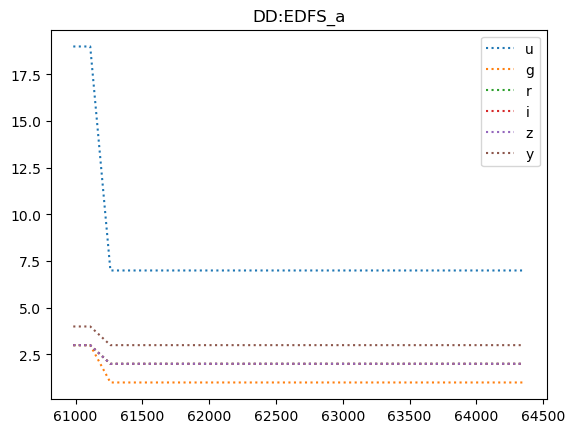

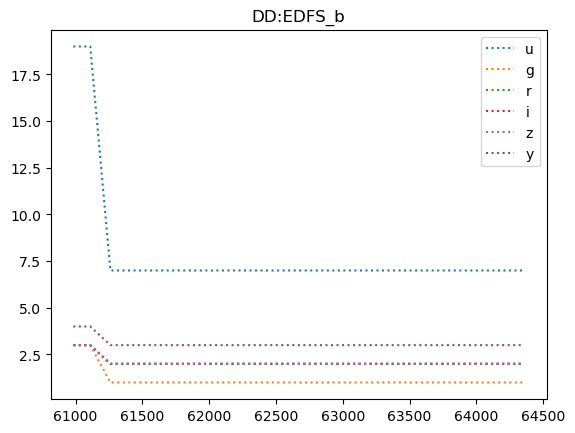

In [152]:
for ddf in d.scheduler_note.unique():
    q = d.query("scheduler_note == @ddf")
    g = q.groupby(['band', 'mjd']).agg(num = ('ID', 'count'))
    g.reset_index('mjd', inplace=True)
    plt.figure()
    for band in 'ugrizy':
        plt.plot(g.loc[band]['mjd'], g.loc[band]['num'], linestyle=':', label=band)
    plt.legend()
    plt.title(ddf)

In [153]:
# What about the actual visits?

#conn = sqlite3.connect("/Users/lynnej/opsim/fbs_4.3/baseline_v4.3_10yrs.db")
conn = sqlite3.connect("/Users/lynnej/opsim/fbs_4.3/desc_ddf_v4.310yrs.db")
visits = pd.read_sql("select * from observations where scheduler_note like 'DD%'", conn)


In [154]:
q = visits.query('target_name == "DD:COSMOS"')
g = q.groupby('night').agg(ra = ('fieldRA', 'mean'), ra_diff = ('fieldRA', np.ptp), dec = ('fieldDec', 'mean'), dec_diff = ('fieldDec', np.ptp))

In [155]:
g.ra.min(), g.ra.max(), g.ra.max() - g.ra.min(), np.std(g.ra.values), g.dec.min(), g.dec.max(), g.dec.max() - g.dec.min(), np.std(g.dec.values)

(149.909803897179,
 150.30208959211436,
 0.39228569493536725,
 np.float64(0.09764946541479168),
 2.0351002227370936,
 2.4291707537360248,
 0.3940705309989312,
 np.float64(0.10218825153789529))

DD:ELAISS1 desired 17.832535885167463 17 35 627 visits 12.064885496183207 3 32 524
DD:XMM_LSS desired 80.10250569476082 17 167 878 visits 71.76965517241379 3 324 725
DD:ECDFS desired 18.26365054602184 17 35 641 visits 11.876977152899824 1 32 569
DD:COSMOS desired 79.48884381338742 17 167 986 visits 68.68342857142858 3 361 875
DD:EDFS_a desired 18.341614906832298 17 35 322 visits 11.784246575342467 3 31 292
DD:EDFS_b desired 18.341614906832298 17 35 322 visits 11.784246575342467 3 31 292


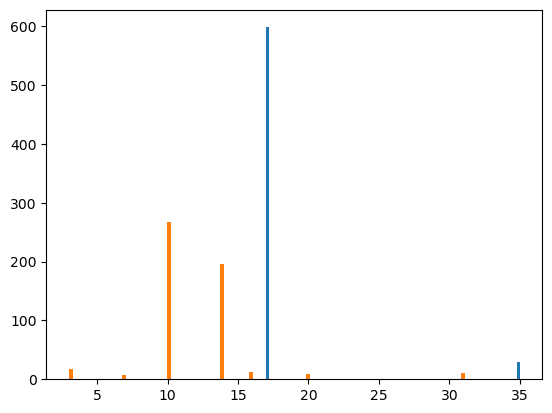

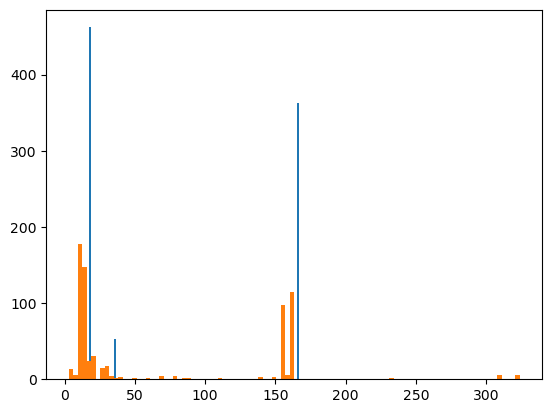

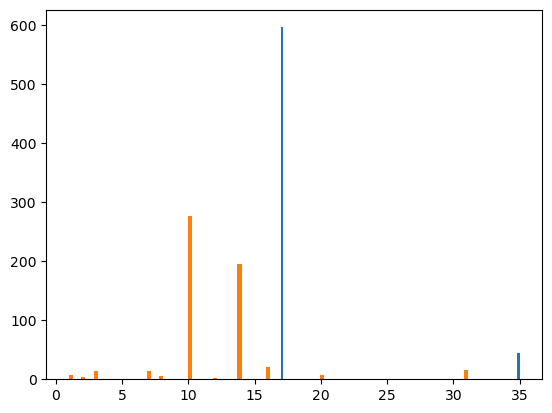

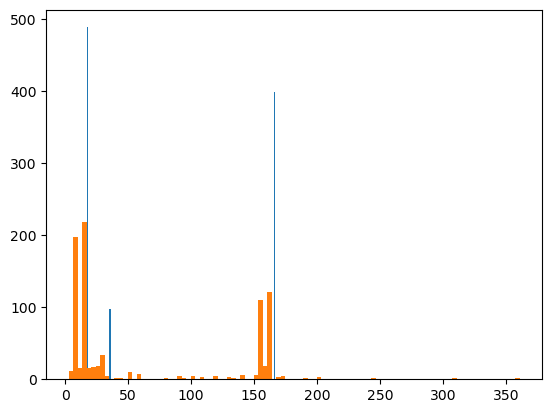

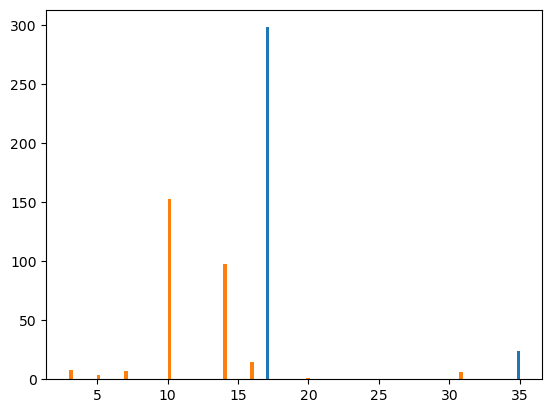

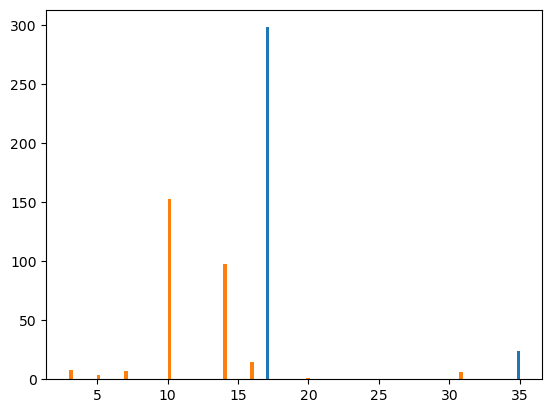

In [156]:
for ddf in d.scheduler_note.unique():
    plt.figure()
    q = d.query("scheduler_note == @ddf")
    g = q.groupby('mjd').agg(seq = ('mjd', 'count'))
    plt.hist(g.seq, bins=100)
    qv = visits.query("target_name == @ddf")
    gv = qv.groupby('night').agg(seq= ('observationStartMJD', 'count'))
    plt.hist(gv.seq, bins=100)
    print(ddf, 'desired', g.seq.mean(), g.seq.min(), g.seq.max(), len(g), 'visits', gv.seq.mean(),  gv.seq.min(), gv.seq.max(), len(gv))

In [157]:
for ddf in d.scheduler_note.unique():
    q = d.query("scheduler_note == @ddf")
    qv = visits.query("target_name == @ddf")
    print(ddf, 'desired', len(q), 'visits', len(qv))

DD:ELAISS1 desired 11181 visits 6322
DD:XMM_LSS desired 70330 visits 52033
DD:ECDFS desired 11707 visits 6758
DD:COSMOS desired 78376 visits 60098
DD:EDFS_a desired 5906 visits 3441
DD:EDFS_b desired 5906 visits 3441


In [158]:
len(d)/2015407.00, len(visits)/2015407.00

(0.09100196635220578, 0.0664610175512936)